In [9]:
from werkzeug.wrappers import Request, Response
from jinja2 import Template
from datetime import datetime, timedelta
import collections
from datetime import datetime

from amigocloud import AmigoCloud

ValueError: greenlet.greenlet size changed, may indicate binary incompatibility. Expected 144 from C header, got 40 from PyObject

In [3]:
# ruta de carpera donde estan las llaves
ruta = open('../ruta.txt')
ruta = ruta.readlines()[0]

# leer token
acceso = open(ruta + '/_keys/api_amigocloud.key','r')
api_token = acceso.readlines()[0]
acceso.close()
amigocloud = AmigoCloud(token=api_token)
amigocloud

In [22]:
ruta

'G:\\OneDrive - Ingenio Azucarero Guabira S.A\\_DATOS_PYTHON'

In [4]:
id=112

In [5]:
# DATOS DE LAS INPECCION
query = {'query': 'select CURRENT_DATE, * from dataset_292618 where id = {id}'.format(id=id)}
project = 'https://app.amigocloud.com/api/v1/projects/31874/sql'
select = amigocloud.get(project, query)
data = select['data'][0]
data['date'] = datetime.strptime(data['date'][0:10], '%Y-%m-%d').strftime('%d/%m/%Y')
data['fecha_quema'] = datetime.strptime(data['fecha_quema'][0:10], '%Y-%m-%d').strftime('%d/%m/%Y')
data['fecha_inspeccion'] = datetime.strptime(data['fecha_inspeccion'][0:10], '%Y-%m-%d').strftime('%d/%m/%Y')

insp = collections.namedtuple("insp", data.keys())(*data.values())
print('end')

end


In [6]:
insp

insp(date='26/09/2023', fecha_registro='2023-09-15 14:19:40+00:00', amigo_id='c08fe291239b4e3cac1e7ebc0ed193e5', fecha_quema='14/09/2023', fecha_inspeccion='15/09/2023', fecha_update='2023-09-26 13:36:30.473684+00:00', canhero='13132 / ZUMARAN MENACHO JORGE', superficie_total=59.56, rendimiento=60.0, produccion=3573.6, responsable='Rogelio Acuña Rodríguez', inicio_incendio='Fuera de la propiedad', causa='Origen desconocido', responsable_de_quema='CAZADOR', observaciones=None, link_informe='https://drive.google.com/file/d/1Wj4dO1t35hVe6Qz2pUrdYPecr3OU7y9-/view?usp=sharing', link_informe_editable=None, cite=362, link_comprobante=None, id=112, tipo_cosecha='SEMI-MECANIZADO')

In [7]:
# DATOS DE LA PROPIEDAD
query = {'query': 'select * from dataset_293179 where insp_ref_prop = \'{insp_ref_prop}\''.format(insp_ref_prop=insp.amigo_id)}
project = 'https://app.amigocloud.com/api/v1/projects/31874/sql'
select = amigocloud.get(project, query)
propiedades_data = select['data']
print('end')

end


In [8]:
propiedades_data

[{'ubicacion': '0101000020E610000060CF93E081B84FC070A0B1C66B5F31C0',
  'amigo_id': '57c2b2cc4eef4e5fae5a3b7b0f15a4c0',
  'fecha_registro': '2023-09-15 14:07:04+00:00',
  'fecha_update': '2023-09-15 14:22:00.654234+00:00',
  'propiedad': '1719 / SANTA FE--ZUMARAN JORGE',
  'tenencia': 'Alquilado',
  'insp_ref_prop': 'c08fe291239b4e3cac1e7ebc0ed193e5'}]

In [9]:
propiedades = []
for prop in propiedades_data:
    prop['lote'] = []
    query_lotes = {'query': 'select * from dataset_293180 where prop_ref_lote = \'{prop_ref_lote}\''.format(prop_ref_lote=prop['amigo_id'])}
    project = 'https://app.amigocloud.com/api/v1/projects/31874/sql'
    lotes_select = amigocloud.get(project, query_lotes)
    for lote_select in lotes_select['data']:
        lote = collections.namedtuple("lote", lote_select.keys())(*lote_select.values())
        prop['lote'].append(lote)
    propiedades.append(collections.namedtuple("propiedad", prop.keys())(*prop.values()))
print('end')

end


In [10]:
propiedades

[propiedad(ubicacion='0101000020E610000060CF93E081B84FC070A0B1C66B5F31C0', amigo_id='57c2b2cc4eef4e5fae5a3b7b0f15a4c0', fecha_registro='2023-09-15 14:07:04+00:00', fecha_update='2023-09-15 14:22:00.654234+00:00', propiedad='1719 / SANTA FE--ZUMARAN JORGE', tenencia='Alquilado', insp_ref_prop='c08fe291239b4e3cac1e7ebc0ed193e5', lote=[lote(geometria='0106000020E6100000010000000103000000010000000C000000A81A13598BB74FC03B7D89CD8B6031C03A7D3C5791B74FC0998A2252746031C0DA632ECAA5B74FC06063C8D5256031C03699EA3CACB74FC0AD6D2C4A096031C030D52F70B6B74FC04B3761AAE55F31C07D95EF85B3B74FC01DD5B194E55F31C0A92EA54DABB74FC0E1783A1FF45F31C09405E952A5B74FC0F9FE28E5FD5F31C0C6CC44B78AB74FC04AADD169666031C0148223DB85B74FC0305302C8856031C072E3AE6B86B74FC0D1674BA1956031C0A81A13598BB74FC03B7D89CD8B6031C0', amigo_id='9e59a1a1c05d4fcd99fd6fb1e16357ac', fecha_registro='2023-09-15 14:02:38+00:00', fecha_update='2023-09-15 14:12:23.909656+00:00', lote='L4', superficie=0.86, observaciones=None, prop_ref_lote='57c2b2cc4

In [12]:
# selecciona todas las fotos y nombre de lotes basado en el id de la inspeccion
query_fotos = {'query': 'select l.lote, g.s3_filename file_name from gallery_42303 g\
                            inner join dataset_293180 l on l.amigo_id = g.source_amigo_id\
                            inner join dataset_293179 p on p.amigo_id = l.prop_ref_lote\
                            inner join dataset_292618 i on i.amigo_id = p.insp_ref_prop\
                            where i.id = {src_id}'.format(src_id=id)}
project = 'https://app.amigocloud.com/api/v1/projects/31874/sql'
select = amigocloud.get(project, query_fotos)
fotos = select['data']
fotos

[{'lote': 'L1', 'file_name': 'WhatsApp Image 2023-09-15 at 9.21.40 AM.jpeg'},
 {'lote': 'L2', 'file_name': 'WhatsApp Image 2023-09-15 at 9.21.41 AM.jpeg'}]

In [13]:
from shapely import wkb
import geopandas
import pandas as pd
import contextily as ctx
import matplotlib.pyplot as plt

def convertir_wkb(wkb_data):
    return wkb.loads(wkb_data, hex=True)[0]

In [14]:
ruta

'G:\\OneDrive - Ingenio Azucarero Guabira S.A\\_DATOS_PYTHON'

end


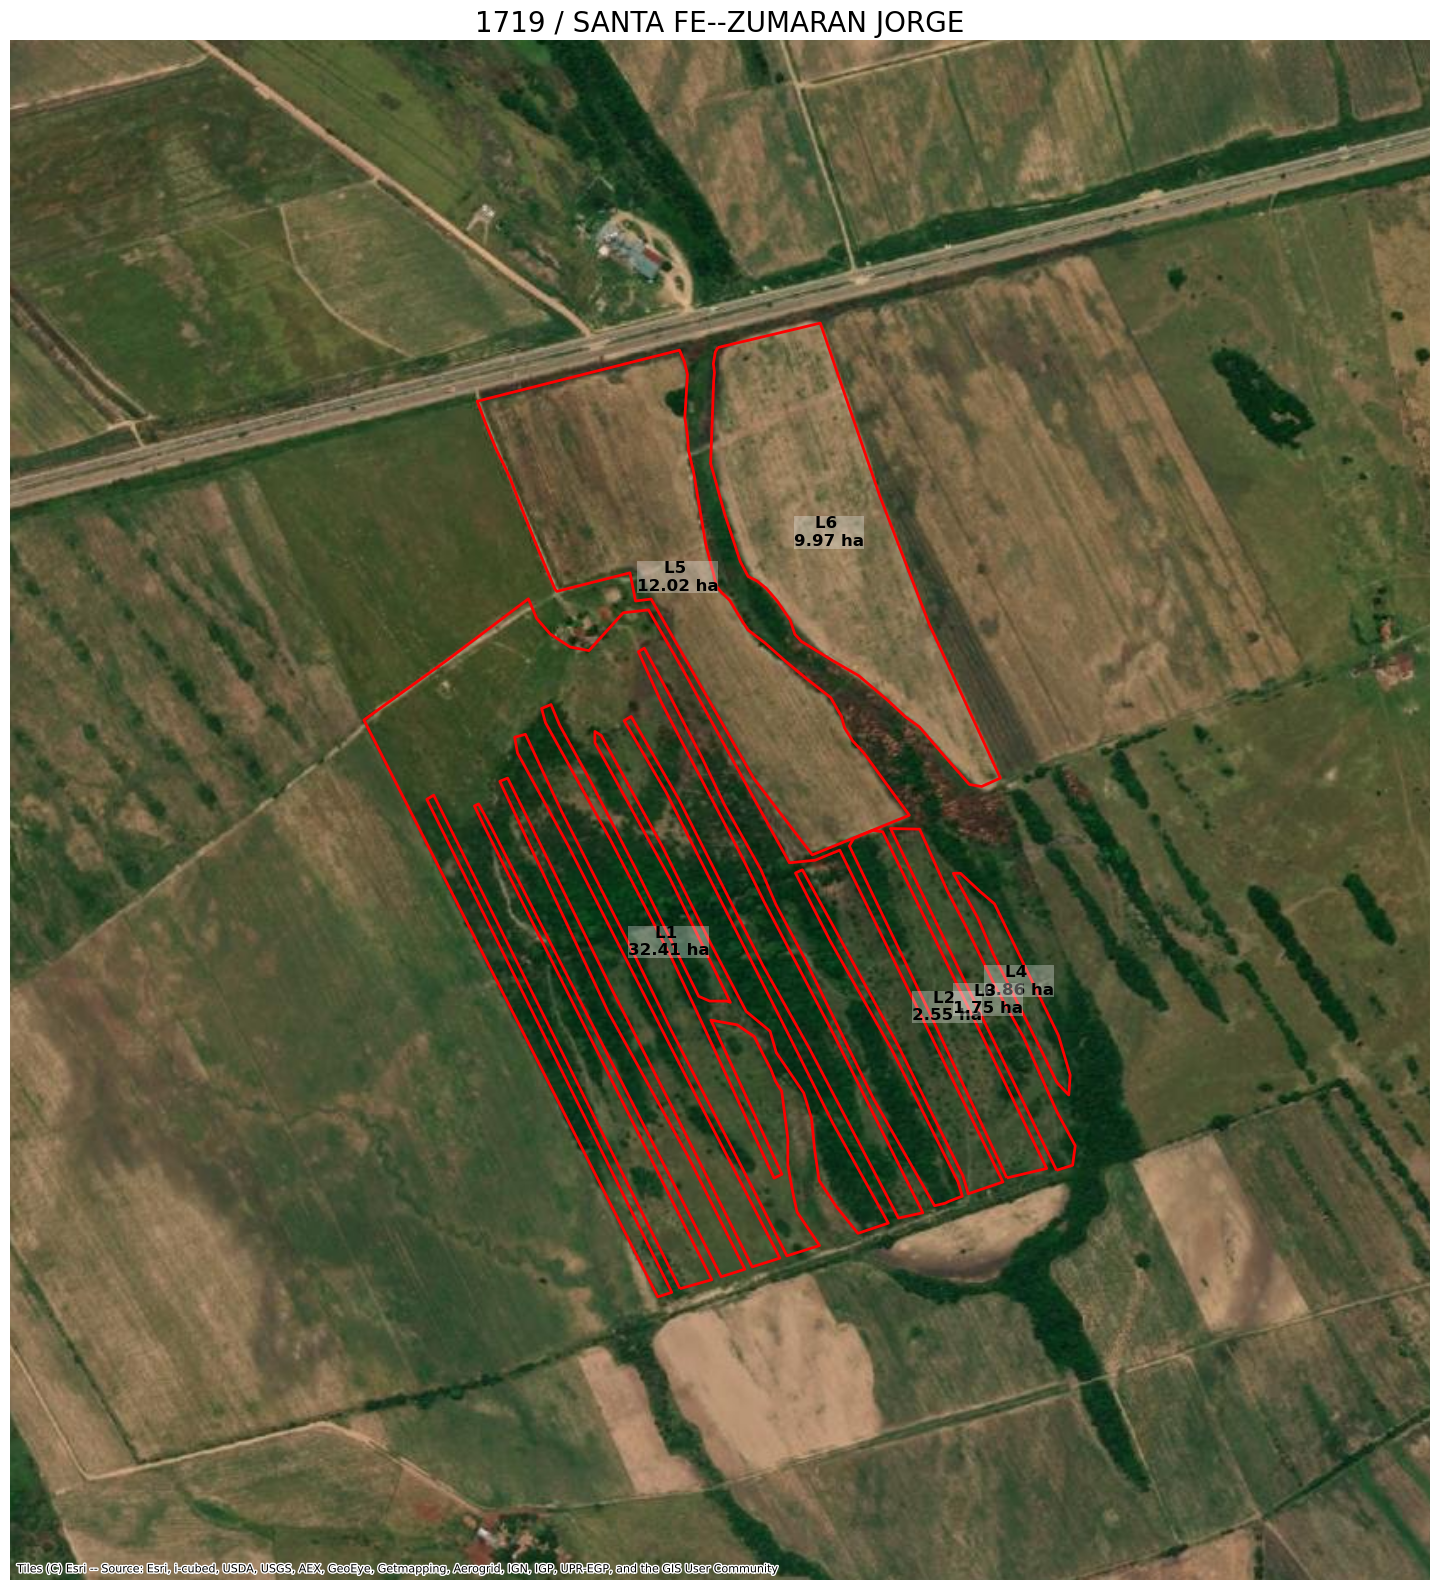

In [15]:
i = 0
lista_planos = []
path = ''
for propiedad in propiedades:
    i = i + 1
    lotes_lista = []
    for lote in propiedad.lote:
        lotes_lista.append(lote._asdict())
    df = pd.DataFrame(lotes_lista)
    df['geometria'] = df['geometria'].apply(convertir_wkb)

    #Convertir a GeoDataFrame
    data = geopandas.GeoDataFrame(df, geometry='geometria')
    #data
    #ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery)

    data['coords'] = data['geometria'].apply(lambda x: x.representative_point().coords[:])
    data['coords'] = [coords[0] for coords in data['coords']]

    data.crs = "EPSG:4326"
    data = data.to_crs(epsg=3857)

    
    fig = plt.figure(i, figsize=(20,20))
    #fig = plt.figure(1)
    ax = None
    ax = fig.add_subplot()

    #data.set_crs(epsg=4326, inplace=True)

    data.apply(lambda x: ax.annotate(text=x.lote + ' \n' + str(x.superficie) + ' ha', xy=x.geometria.centroid.coords[0], ha='center', va='center', color='black', fontsize=12, weight=1000, bbox=dict(facecolor=(1,1,1,0.3), edgecolor='none', pad=0)), axis=1);

    #data.boundary.plot(ax=ax, color=(0,0,0,0), linewidth=0)

    #data = data.to_crs(epsg=3857)

    minx, miny, maxx, maxy = data.total_bounds
    ax.set_xlim(minx - 500, maxx + 500)
    ax.set_ylim(miny - 400, maxy + 400)

    data.plot(ax=ax, edgecolor='r', facecolor=(0,0,0,0), linewidth=2, figsize=(20,20))
    #data.plot(ax=ax, edgecolor='r', facecolor=(0,0,0,0), linewidth=2)
    
    ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery)
    ax.set_axis_off()
    ax.set_title(str(propiedad.propiedad), fontsize=20)
    path = ruta + '/planos/' + str(insp.amigo_id) + '_' + str(propiedad.amigo_id) + '.jpeg'
    lista_planos.append(path)
    fig.savefig(path, dpi = 300, bbox_inches='tight')
    del fig
print('end')

In [16]:
from docxtpl import DocxTemplate
import docxtpl
from docx.shared import Mm

import requests

doc = DocxTemplate(ruta + "/templates/tpl_infome_quema.docx")

#generar lista de InlineImage de planos 
lista_InlineImage = []
for plano in lista_planos:
    lista_InlineImage.append(docxtpl.InlineImage(doc, image_descriptor=plano, width=Mm(150)))

#descargar fotos y generar lista InlineImage
lista_fotos_inline = []
for foto in fotos:
    #response = requests.get("https://www-amigocloud.s3.amazonaws.com/gallery/" + foto['file_name'])
    response = requests.get("https://www-amigocloud.s3.amazonaws.com/gallery/" + foto['file_name'])
    file = open(ruta + '/fotos/' + foto['file_name'], "wb")
    file.write(response.content)
    file.close()
    lista_fotos_inline.append({'foto': docxtpl.InlineImage(doc, image_descriptor= ruta + '/fotos/' + foto['file_name'], width=Mm(120)), 'lote': foto['lote']})

firma_respon = None
if insp.responsable == 'Rogelio Acuña Rodríguez':
    firma_respon = docxtpl.InlineImage(doc, image_descriptor=ruta + '/templates/firma_rogelio.png', width=Mm(60))
else:
    firma_respon = docxtpl.InlineImage(doc, image_descriptor=ruta + '/templates/firma_jaldin.png', width=Mm(60))

context = {'insp':insp, 'propiedades':propiedades, 'planos':lista_InlineImage, 'fotos':lista_fotos_inline, 'firma':firma_respon}

doc.render(context)

# formato de nombre de archivo: "123_CQ_01-01-2022_NOMBRE"
cod_nom = insp.canhero.split(' / ')
file_name = cod_nom[0] + '_CAQ_' + insp.fecha_inspeccion.replace('/','-') + '_' + cod_nom[1] + '_' + str(insp.id)

doc.save(ruta + '/informes/_' + file_name + '.docx')